In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import feature
import warnings
import json
warnings.filterwarnings('ignore')

# Data Preparations
A general assumption for the machine learning is that the training and test data are all [independent and identically distributed (_i.i.d._)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) from the same probability distribution. Therefore, the first step for the data clean up is always to __combine the training data and test data__.

In [2]:
data = feature.DataCleaner('data.json')


The common columns are: 
['MasVnrType', 'RoofMatl', 'MoSold', 'BsmtUnfSF', 'LotArea', 'Condition1', 'KitchenAbvGr', 'LotShape', 'TotalBsmtSF', 'SaleCondition', 'Heating', 'PavedDrive', 'BsmtFinSF2', 'GarageType', 'OpenPorchSF', 'BsmtFullBath', 'Neighborhood', 'BedroomAbvGr', 'GarageCars', '3SsnPorch', 'HouseStyle', '2ndFlrSF', 'Exterior1st', 'Id', 'MasVnrArea', 'Foundation', 'LandSlope', 'MSZoning', 'CentralAir', 'GarageCond', 'Condition2', 'Alley', 'OverallQual', 'MSSubClass', 'Electrical', 'BsmtFinType1', 'GarageQual', 'MiscFeature', 'BsmtExposure', 'FireplaceQu', 'LotConfig', 'BsmtCond', 'ScreenPorch', 'HalfBath', 'YrSold', 'OverallCond', 'LandContour', 'BsmtFinSF1', 'HeatingQC', 'GarageYrBlt', '1stFlrSF', 'BsmtHalfBath', 'FullBath', 'LowQualFinSF', 'Fireplaces', 'YearBuilt', 'LotFrontage', 'PoolArea', 'KitchenQual', 'Utilities', 'BsmtQual', 'GrLivArea', 'EnclosedPorch', 'PoolQC', 'MiscVal', 'BldgType', 'Street', 'WoodDeckSF', 'ExterCond', 'BsmtFinType2', 'RoofStyle', 'ExterQual', 

From the data descriptions, there are many variables which have NaN that need to be considered as absence of the property.

In [3]:
fill_dict = {"NoBsmt": ["BsmtFinType1", "BsmtCond", "BsmtFinType2", "BsmtExposure", "BsmtQual"],
             "NoGarage": ["GarageCond", "GarageQual", "GarageFinish", "GarageType"],
             "NoPool": ["PoolQC"],
             "NoFirePlace": ["FireplaceQu"],
             "NoFence":["Fence"],
             "NoAccess": ["Alley"],
             "None": ["MiscFeature", "MasVnrType"]
             }
data.fill_na_spec(fill_dict)

Column Fence 's empty value has been replaced by NoFence
Column MiscFeature 's empty value has been replaced by None
Column MasVnrType 's empty value has been replaced by None
Column FireplaceQu 's empty value has been replaced by NoFirePlace
Column Alley 's empty value has been replaced by NoAccess
Column PoolQC 's empty value has been replaced by NoPool
Column BsmtFinType1 's empty value has been replaced by NoBsmt
Column BsmtCond 's empty value has been replaced by NoBsmt
Column BsmtFinType2 's empty value has been replaced by NoBsmt
Column BsmtExposure 's empty value has been replaced by NoBsmt
Column BsmtQual 's empty value has been replaced by NoBsmt
Column GarageCond 's empty value has been replaced by NoGarage
Column GarageQual 's empty value has been replaced by NoGarage
Column GarageFinish 's empty value has been replaced by NoGarage
Column GarageType 's empty value has been replaced by NoGarage

 Now the columns have been updated:
['Fence', 'MiscFeature', 'MasVnrType', 'Fire

In the variables related to garage, there is one empty value in `GarageArea` and `GarageCars` when it has the `GarageType = Detchd`. So one can impute the missing value with the median value of the `GarateArea` when `GarageType = Detchd`. 

In [4]:
print ("The GarageType is " + data.all_data.loc[data.all_data.GarageArea.isnull(),'GarageType'] + 
       ", when the Garage Area is empty")
group = {("GarageType", "Detchd"): ["GarageArea", "GarageCars"] }
data.fill_na_group(group)

2576    The GarageType is Detchd, when the Garage Area...
Name: GarageType, dtype: object
Now column GarageArea 's empty value has been replaced by 399.5
Now column GarageCars 's empty value has been replaced by 2.0

 Now the columns have been updated:
['GarageArea', 'GarageCars']
Now the column name(s) that have empty values are:
LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
MSZoning          4
Functional        2
Utilities         2
BsmtHalfBath      2
BsmtFullBath      2
Exterior2nd       1
Exterior1st       1
TotalBsmtSF       1
BsmtFinSF2        1
BsmtFinSF1        1
Electrical        1
SaleType          1
KitchenQual       1
BsmtUnfSF         1
dtype: int64


For Basement areas, if there is no basement, the area should be zero. Similar issues apply Masonry veneer area, Garage area, Pool area, Fireplaces

In [5]:
value_matching = {
    ("NoBsmt", 0): [("BsmtFinType1", "BsmtFinSF1"), ("BsmtFinType2", "BsmtFinSF2"), ("BsmtQual", "TotalBsmtSF"),
                    ("BsmtQual", "BsmtUnfSF")
                    ],
    ("None", 0):[("MasVnrType","MasVnrArea")],
    ("NoGarage", 0) : [("GarageType", "GarageCars"), ("GarageType", "GarageArea")],
    ("NoPool", 0): [("PoolQC", "PoolArea")],
    ("NoFirePlace", 0): [("FireplaceQu", "Fireplaces")]
}
mapping = {("None", 0): [("MiscFeature", "MiscVal")]}
data.convert_value(value_matching)
data.convert_value(mapping, True)


 Now the columns have been updated:
['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 'MasVnrArea', 'PoolArea', 'Fireplaces', 'GarageCars', 'GarageArea']

 Now the columns have been updated:
['MiscVal']


In [6]:
# Now one can impute the missing variables with most common values
data.fill_na_gen()

Now the column name(s) that have empty values are:
LotFrontage     486
GarageYrBlt     159
MSZoning          4
Functional        2
Utilities         2
BsmtHalfBath      2
BsmtFullBath      2
Exterior2nd       1
SaleType          1
KitchenQual       1
Electrical        1
Exterior1st       1
dtype: int64
Now column LotFrontage 's empty value has been replaced by 68.0
Now column GarageYrBlt 's empty value has been replaced by 1979.0
Now column MSZoning 's empty value has been replaced by RL
Now column Functional 's empty value has been replaced by Typ
Now column Utilities 's empty value has been replaced by AllPub
Now column BsmtHalfBath 's empty value has been replaced by 0.0
Now column BsmtFullBath 's empty value has been replaced by 0.0
Now column Exterior2nd 's empty value has been replaced by VinylSd
Now column SaleType 's empty value has been replaced by WD
Now column KitchenQual 's empty value has been replaced by TA
Now column Electrical 's empty value has been replaced by SBrkr
N

It looks like mapping is way faster than apply funciton.

In [7]:
interpret_mapping = {
    'MSSubClass': { 20: "SubClass_20",
                     30: "SubClass_30",
                     40: "SubClass_40",
                     45: "SubClass_45",
                     50: "SubClass_50",
                     60: "SubClass_60",
                     70: "SubClass_70",
                     75: "SubClass_75",
                     80: "SubClass_80",
                     85: "SubClass_85",
                     90: "SubClass_90",
                     120: "SubClass_120",
                     150: "SubClass_150",
                     160: "SubClass_160",
                     180: "SubClass_180",
                     190: "SubClass_190"},
    'Street': { 'Grvl' : 0,
                'Pave': 1},
    'Alley': { 'Grvl': 0,
               'Pave': 1,
               'NoAccess': -1},
    'LotShape': {'Reg' : 0,
                 'IR1' : 1,
                 'IR2' : 2,
                 'IR3' : 3 },
    'Utilities': {'AllPub': 3,
                  'NoSewr' : 2,
                  'NoSeWa': 1,
                  'ELO': 0},
    'LandSlope': {'Gtl' : 0,
                  'Mod' : 1,
                  'Sev' : 2},
    'ExterQual': {'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'Fa' : 2,
                  'Po' : 1},
    'ExterCond': {'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'FA' : 2,
                  'Po' : 1},
    'BsmtQual': {'Ex' : 5,
                 'Gd' : 4,
                 'TA' : 3,
                 'Fa' : 2,
                 'Po' : 1,
                 'NoBsmt' : 0},
    'BsmtCond': {'Ex' : 5,
                 'Gd' : 4,
                 'TA' : 3,
                 'Fa' : 2,
                 'Po' : 1,
                 'NoBsmt' : 0},
    'BsmtExposure' : {'Gd' : 3,
                      'Av' : 2,
                      'Mn' : 1,
                      'No' : 0,
                      'NoBsmt' : 0},
    'HeatingQC' :{'Ex' : 5,
                  'Gd' : 4,
                  'TA' : 3,
                  'Fa' : 2,
                  'Po' : 1},
    'CentralAir' :{'N' : 0,
                   'Y' : 1},
    'KitchenQual' :{'Ex' : 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1},
    'Functional' : {'Typ' : 0,
                    'Min1' : 1,
                    'Min2' : 1,
                    'Mod' : 2,
                    'Maj1' : 3,
                    'Maj2' : 3,
                    'Sev' : 4,
                    'Sal' : 5},
    'FireplaceQu' : {'Ex' : 5,
                     'Gd' : 4,
                     'TA' : 3,
                     'Fa' : 2,
                     'Po' : 1,
                     },
    'GarageFinish' : {'Fin' : 2,
                      'RFn' : 1,
                      'Unf' : 0,
                      'NoGarage': 0},
    'GarageQual' : {'Ex' : 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1,
                    'NoGarage': 0},
    'GarageCond' : {'Ex': 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1,
                    'NoGarage' : 0},
    'PavedDrive' : {'Y' : 2,
                    'P' : 1,
                    'N' : 0},
      'PoolQC': {'Ex' : 4,
                 'Gd' : 3,
                 'TA' : 2,
                 'Fa' : 1,
                 'NoPool': 0},
      'Fence': {'GdPrv': 2,
                'MnPrv': 1,
                'GdWo': 2,
                'MnWw': 1,
                'NoFence': 0
                },
}
data.interpret_value(interpret_mapping)

# Remove Skew from Price values
After exploring the distribution of the price values, we can take the logarithm to change the shape of the variable to reduce the skewness of the variables.

In [8]:
X_train = data.all_data[:data.train.shape[0]]
y = data.train['SalePrice']
X = pd.concat((X_train, y), axis = 1)
X.drop("Id", axis=1, inplace=True)

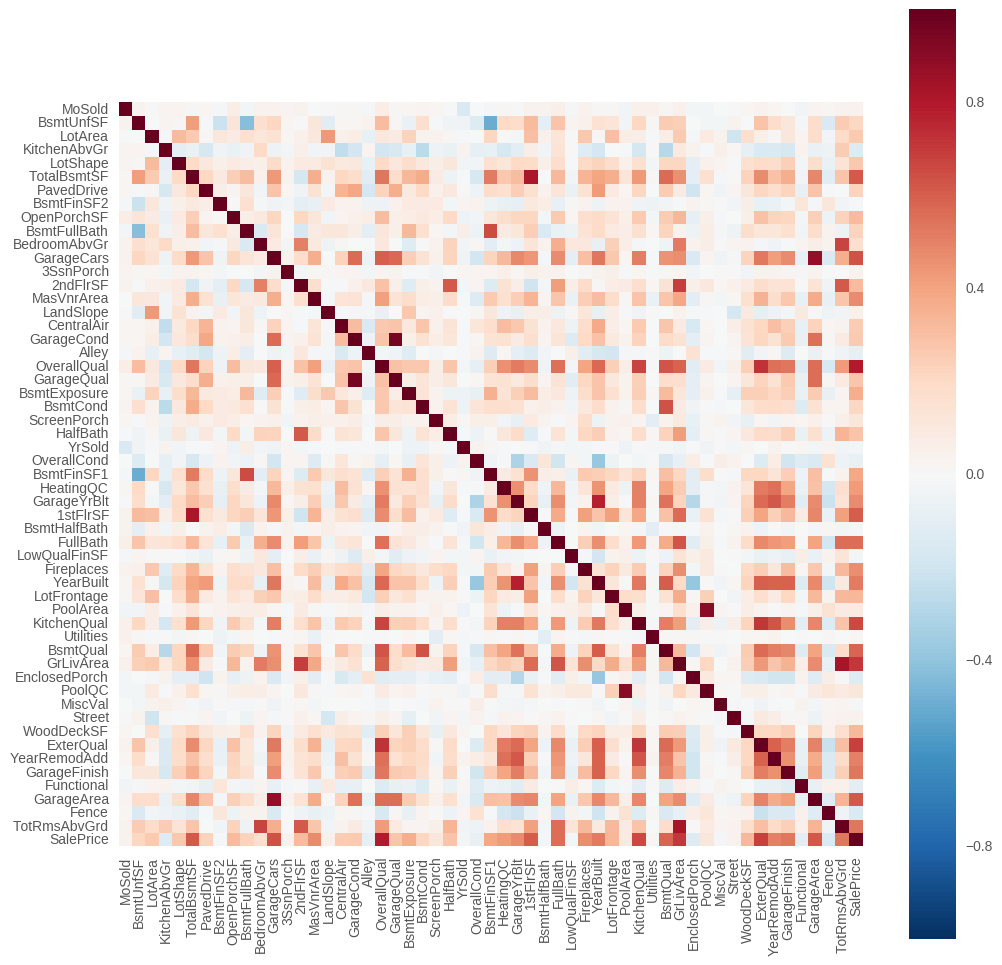

In [9]:
corr = X.select_dtypes(include = ["float64", "int64"]).corr()
plt.figure(figsize = (12,12))
sns.heatmap(corr, vmax=1, square=True)

In [10]:
cor_dict = corr['SalePrice'].to_dict()
del cor_dict["SalePrice"]
print("List the numerical features decendingly by their correlation with Sale Price:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the numerical features decendingly by their correlation with Sale Price:

OverallQual: 	0.7909816005838047
GrLivArea: 	0.7086244776126511
ExterQual: 	0.6826392416562591
KitchenQual: 	0.6595997207286572
GarageCars: 	0.640409197258349
GarageArea: 	0.6234314389183598
TotalBsmtSF: 	0.6135805515591944
1stFlrSF: 	0.6058521846919166
BsmtQual: 	0.5852071991725148
FullBath: 	0.5606637627484452
GarageFinish: 	0.5372421226773492
TotRmsAbvGrd: 	0.5337231555820238
YearBuilt: 	0.5228973328794967
YearRemodAdd: 	0.5071009671113867
MasVnrArea: 	0.4734607086005904
GarageYrBlt: 	0.46905607526113297
Fireplaces: 	0.4669288367515242
HeatingQC: 	0.4276487073988049
BsmtFinSF1: 	0.38641980624215627
BsmtExposure: 	0.36186283187566154
LotFrontage: 	0.3345439407773447
WoodDeckSF: 	0.32441344456813076
2ndFlrSF: 	0.31933380283206614
OpenPorchSF: 	0.31585622711605577
HalfBath: 	0.2841076755947784
GarageQual: 	0.27383907400622587
LotShape: 	0.26775931391782054
LotArea: 	0.2638433538714063
GarageCond: 	0.26319078

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e93803c18>,
        ...,
        ...,
        ...,
       ..., 
        ...,
        ...,
        ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8e54a8fac8>]], dtype=object)

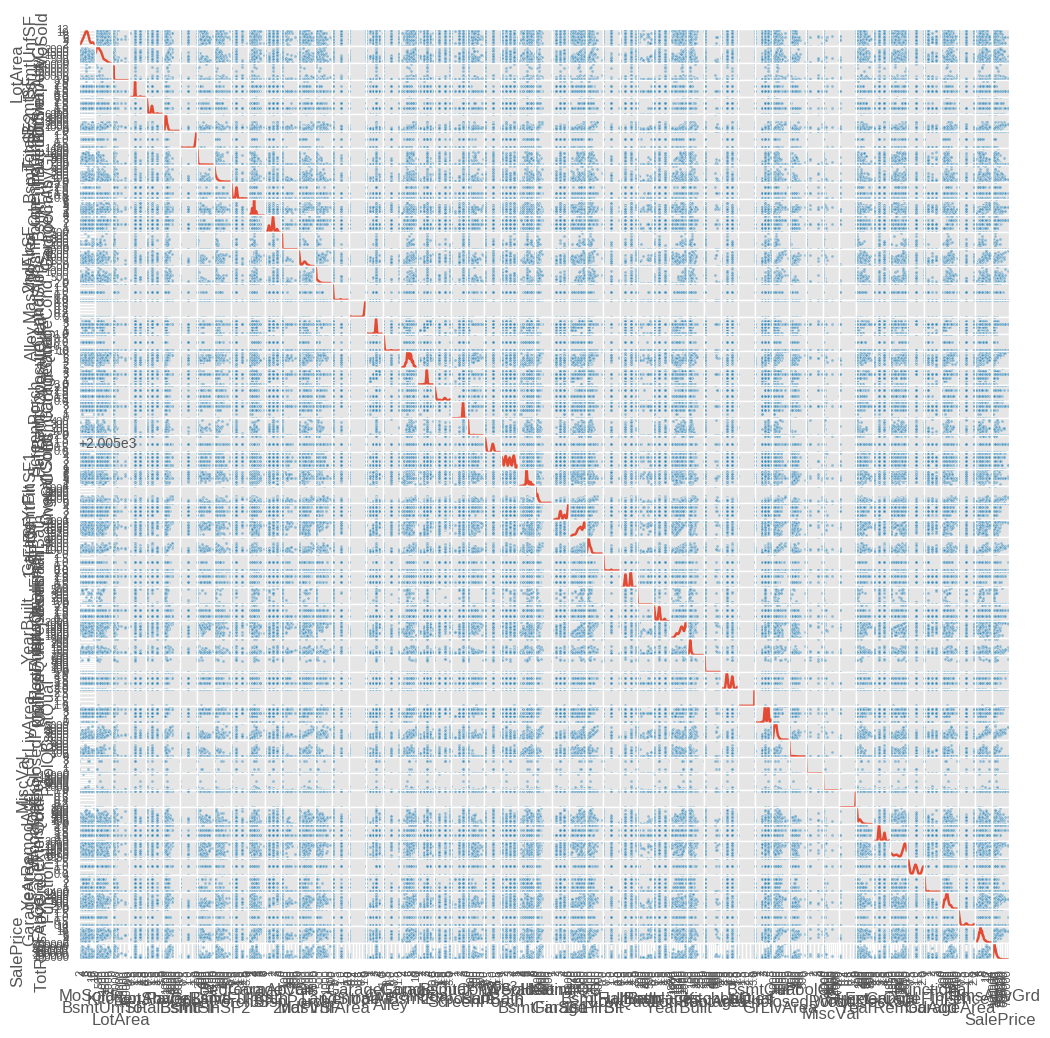

In [11]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(X, figsize=(12,12), diagonal="kde")

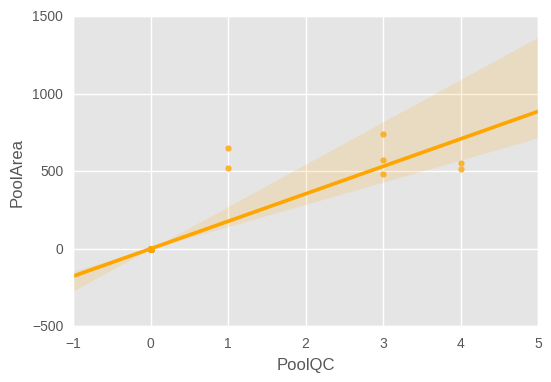

In [12]:
sns.regplot(x = "PoolQC", y = 'PoolArea', data=X, color= "Orange")

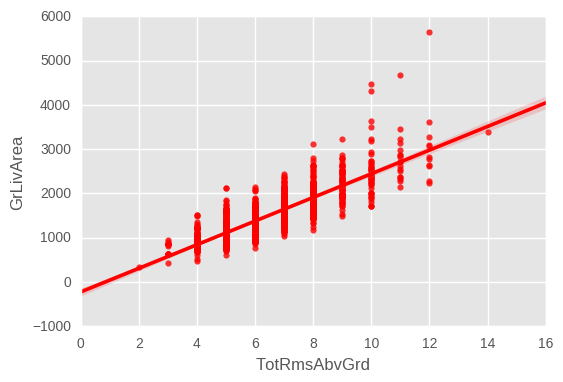

In [13]:
sns.regplot(x = "TotRmsAbvGrd", y = "GrLivArea", data=X, color= "Red")

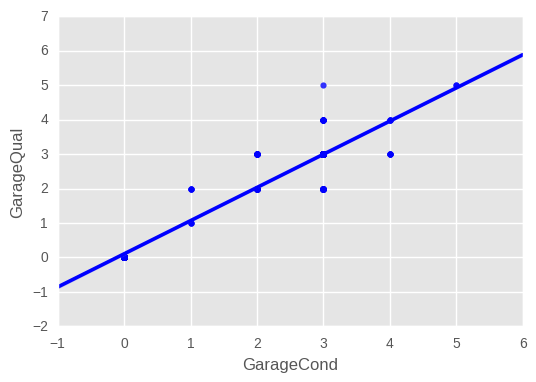

In [14]:
sns.regplot( x = "GarageCond", y = "GarageQual", data=X, color = "Blue")

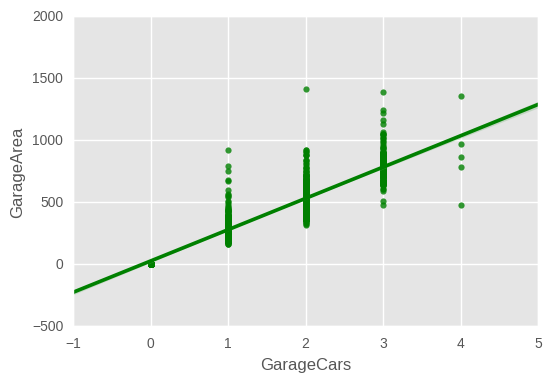

In [15]:
sns.regplot( x = "GarageCars", y = "GarageArea", data = X, color = "Green")

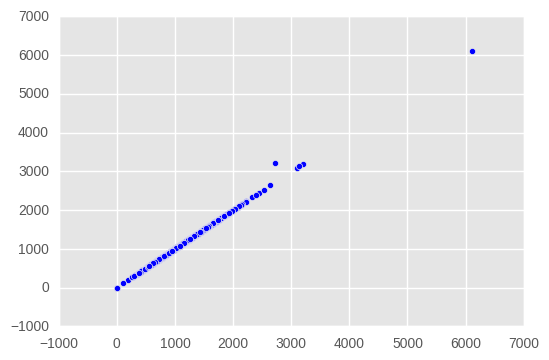

In [16]:
total = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
plt.scatter(total, X["TotalBsmtSF"])

In [ ]:
data.save_dataset("test_data.p")

In [ ]:
X_train, X_test, y = cleaner.prep_for_learn()
print(X_train.shape)
print(y.shape)
print(X_test.shape)

In [ ]:
y = np.log1p(y)

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

In [ ]:
from sklearn.linear_model import Lasso
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [ ]:
model = Lasso(alpha = 5e-4, max_iter =  50000).fit(X_train, y)

In [ ]:
coef = pd.Series(model.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

In [ ]:
p_pred = np.expm1(model.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

In [ ]:
# save to file to make a submission
p = np.expm1(model.predict(X_test))
solution = pd.DataFrame({"id":test_data.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("test.csv", index = False)

In [ ]:
import seaborn as sns
price = train_data[train_data.columns.values[-1]]
log_price = np.log(price)
print ("The skewness of the price is {0}".format(skew(price)))

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
sns.distplot(price, color = 'r', hist_kws = {'alpha': 0.9})
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_price, color = 'r', hist_kws = {'alpha': 0.9})
plt.title('Natual log of Data')
plt.xlabel('Natual log of Sale Price')
plt.tight_layout()

# Handling missing values for numerical variables
* Remove outliers using Median Absolute Deviation
* Calculate skewness of each variable and transform it if greater than 0.75
* Apply the sklearn.Normalizer to each column

  We can compare two different numerical variables: one with skewness handling and normalization, one without it.

In [ ]:
train_num_m = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
train_num = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:,1:]
for col in train_num_m.columns.values:
    if np.sum(train_num_m[col].isnull() ) > 0:
        median = train_num_m[col].median()
        idx = np.where(train_num_m.isnull())[0]
        train_num_m[col].iloc[idx] = median
        train_num[col].iloc[idx] = median
        
        outliers = np.where(is_outlier(train_num_m[col]))
        train_num_m[col].iloc[outliers] = median
        
        if skew(train_num_m[col]) > 0.75:
            train_num_m[col] = np.log(train_num[col])
            train_num_m[col] = train_num_m[col].apply(lambda x: 0 if x == -np.inf else x)
            
        train_num_m[col] = Normalizer().fit_transform(train_num_m[col].reshape(1,-1))[0]

In [ ]:
train_num_m[train_num_m.columns.values[-1]] = np.log(train_num_m[train_num_m.columns.values[-1]])
corr_m = train_num_m.corr()
corr = train_num.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, vmax =1 , square = True)
plt.figure(figsize = (15,15))
sns.heatmap(corr, vmax=1, square = True)

In [ ]:
cor_dict_m = corr_m['SalePrice'].to_dict()
del cor_dict_m['SalePrice']

# raw numerical features
cor_dict = corr["SalePrice"].to_dict()
del cor_dict['SalePrice']

print("The raw numerical features sorted by their correlation with Sale price:\n")
for item in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t {1}".format(*item))

print("\n\nThe modified numerical features sorted by their correlation with Sale price:\n")
for item in sorted(cor_dict_m.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t {1}".format(*item))

In [ ]:
sns.regplot(x='OverallQual', y='SalePrice', data = train_num_m, color='Orange')

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.YearBuilt.values, train_num_m.YearRemodAdd.values)
plt.title("Year Built")
fig.text(-0.01,0.5, 'Year Remodel Added', va="center", rotation = 'vertical', fontsize = 12)
print (corr_m['YearBuilt']['YearRemodAdd'])

In [ ]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.scatter(train_num_m.GarageCars.values, train_num_m.GarageArea.values)
plt.title("Size of Garage for Cars")
fig.text(-0.01,0.5, 'Size of Garage area', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['GarageCars']['GarageArea'])
plt.subplot(1,2,2)
sns.regplot(x='GarageCars', y='GarageArea', data = train_num_m, color='Orange')

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.GarageArea.values, train_num_m.GarageYrBlt.values)
plt.title("Size of Garage")
fig.text(-0.01,0.5, 'The building year for garage', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['GarageArea']['GarageYrBlt'])

In [ ]:
fig = plt.figure()
plt.scatter(train_num_m.YearBuilt.values, train_num_m.GarageYrBlt.values)
plt.title("Year Built")
fig.text(-0.01,0.5, 'The year build the garage', va="center", rotation = 'vertical', fontsize = 12)
print(corr_m['YearBuilt']['GarageYrBlt'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Campare the importances of RF for raw and modified features
rfr = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
y = train_num['SalePrice']
X= train_num.drop('SalePrice', axis=1)

rfr.fit(X,y)
coef = pd.Series(rfr.feature_importances_, index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance for random forest')
plt.tight_layout()

rfr_m = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
y_m = train_num_m['SalePrice']
X_m= train_num_m.drop('SalePrice', axis=1)

rfr_m.fit(X_m,y_m)
coef_m = pd.Series(rfr_m.feature_importances_, index = X_m.columns).sort_values(ascending=False)

plt.subplot(1,2,2)
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance for random forest')
plt.tight_layout()

In [ ]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=1000)
gbr.fit(X,y)
coef = pd.Series(gbr.feature_importances_, index = X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance for gradient boosting trees')
plt.tight_layout()

gbr_m = GradientBoostingRegressor(loss='ls', n_estimators=1000)
y_m = train_num_m['SalePrice']
X_m= train_num_m.drop('SalePrice', axis=1)

gbr_m.fit(X_m,y_m)
coef_m = pd.Series(gbr_m.feature_importances_, index = X_m.columns).sort_values(ascending=False)

plt.subplot(1,2,2)
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance for gradient boosting trees')
plt.tight_layout()

In [ ]:
_,pval = f_regression(X, y)
coef = pd.Series(pval, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
coef.head(25).plot(kind='bar')
plt.title('Raw Feature Significance')
plt.tight_layout()

_,pval_m = f_regression(X_m, y)
coef_m = pd.Series(pval_m, index=X_m.columns).sort_values(ascending=True)

plt.subplot(1,2,2) 
coef_m.head(25).plot(kind='bar')
plt.title('Modified Feature Significance')
plt.tight_layout()

# Categorical Variables

In [ ]:
cat_value = train_data.select_dtypes(include=['object']).iloc[:,1:]

In [ ]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = train_data)
xt = plt.xticks(rotation = 45)

In [ ]:
plt.figure (figsize = (12, 6))
sns.countplot(x = 'Neighborhood', data = cat_value)
xt = plt.xticks(rotation = 45)